In [2]:
import numpy as np
import sympy
import random
import math
import matplotlib.pyplot as plt
from sympy import *
import scipy
from scipy.stats import chi2  
from scipy.stats import multivariate_t
from scipy.stats import cauchy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from csv import reader
import numpy as np
import sympy
import random
import math
import numpy as np
def pre_process(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = list(reader(f))
    data = np.array(data)    
    return data

df = pre_process('./nycflight.csv')

In [3]:
df = df[1:len(df):]
df = df.astype(np.float64) 
X = np.array(df[:,6].reshape(-1,1))
y = np.array(df[:,1].reshape(-1,1))

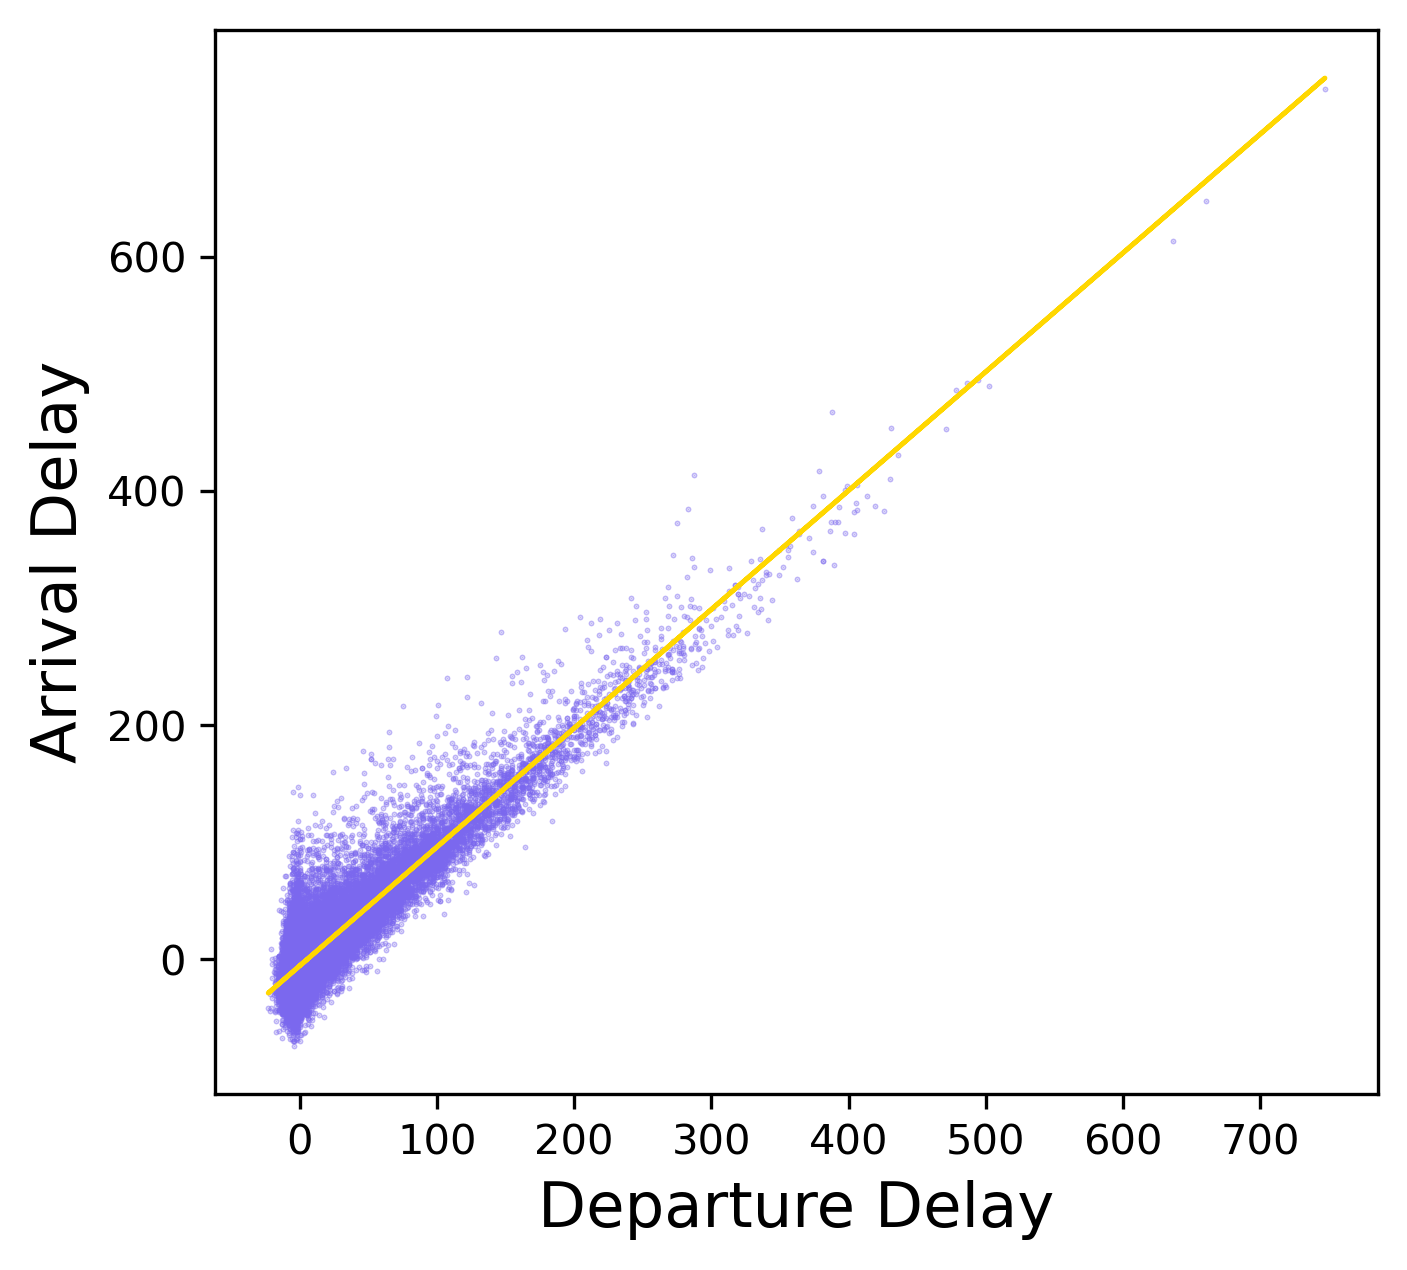

In [4]:
# 1-d regression
x_full = X
y_full = y
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300,figsize=(5,4.7))

plt.scatter(x_full, y_full, color="mediumslateblue",s=0.15,alpha=0.5)
regr1 = linear_model.LinearRegression()

regr1.fit(x_full, y_full)

y_pred = regr1.predict(x_full)
plt.plot(x_full, y_pred, color="gold", linewidth=1.15)

plt.xlabel('Departure Delay',size=15)
plt.ylabel('Arrival Delay',size=15)
plt.savefig('nyc_linear.png',bbox_inches = 'tight')
plt.show()

In [9]:
np.random.seed(3)
a = np.zeros((len(x_full),1),dtype=int)
for i in range(len(a)):
    a[i] = int(i)
state = np.random.get_state()
np.random.shuffle(a)

ols_example = 50448
inv_example = 60448 - ols_example

a = a.T[0]
# print(a)
X_OLS = x_full[a[0:ols_example]]
X_inv = x_full[a[ols_example:60448]]

y_OLS = y_full[a[0:ols_example]]
y_inv = y_full[a[ols_example:60448]]

regr = linear_model.LinearRegression()

regr.fit(X_OLS, y_OLS)

y_pred = regr.predict(X_OLS)

print("Coefficients: \n", regr.coef_)
theta0 = regr.coef_[0]

Coefficients: 
 [[1.01630131]]


In [10]:
var_est = np.linalg.norm(y_OLS - X_OLS * theta0,ord=2)* sqrt(1/(len(y_OLS)-1))
print(var_est)

18.0414475608510


In [11]:
x = X_inv
y = y_inv
x = x.reshape(-1,1)
y = y.reshape(-1,1)
# semi-parametric option
y = x*theta0 + np.random.normal(0,var_est,len(y)).reshape(-1,1)

In [12]:
permutation = []
K = 1000
tr_example = len(y)-1
te_example = 1
for j in range(K):
    A = np.zeros((tr_example+1,1))
    for i in range(tr_example+1):
        A[i] = i
    np.random.shuffle(A)
    permutation.append(A)

In [15]:
import time
K = 1000
alpha = 0.05
alpha1 = int((K+1) * alpha /2)
alpha2 = K + 1 - alpha1
v_num = int(K*alpha)
inf = 999999
tr_example = len(y)-1
te_example = 1
var_est = 1
    
record = []
for cv in range(1000):
    time1 = time.time()
    print('trial:',cv)
    y = x*theta0 + np.random.normal(0,var_est,len(y)).reshape(-1,1)
    y_train = y[0:(len(y)-1)]
    y_test = y[len(y)-1]
    x_train = x[0:(len(x)-1)]
    x_test = x[len(x)-1]
    n = len(x_train)
    cs_idx = 0
    pb_idx = 0
    gau_idx = 0
    x1 = np.zeros((len(x_train)+1,1))
    for i in range(len(x1)-1):
        x1[i] = x_train[i]
    res = y_train - theta0 * x_train
    temp = np.linalg.inv(np.dot(x_train.T,x_train))
    temp = np.dot(temp,x_train.T)
    thetaols = np.dot(temp,y_train)
    for num in range(len(y_test)):
        xte = x_test[num]
        x1[len(x1)-1] = xte    
        res1 = np.concatenate([res,(y_test[num]-theta0*xte)*np.ones((1,1))])
        res1_n = res1 - np.mean(res1)*np.ones((tr_example+1,1))
        x1_n = x1 - np.mean(x1)*np.ones((tr_example+1,1))
        sum1 = np.dot(x1_n.T,res1_n)
        valid = 0
        # Permutation based
        for j in range(K):
            A = permutation[j]
            res2_n = np.ones((n+1,1))
            for idx_t in range(n+1):
                res2_n[int(A[idx_t])] = res1_n[idx_t]
            sum2 = np.dot(x1_n.T,res2_n)
            if (abs(sum1) < abs(sum2)):
                valid = valid+1
        if valid >= v_num:
            pb_idx = pb_idx + 1

        # Gaussian Pivotal JCR - \yte not in the denominator: (the other one performs really bad; and i don't want \yte on the denominator)
        def S(theta):
            s = np.linalg.norm(y_train - np.dot(x_train,theta),ord=2)
            return s
        y_u_gau = np.dot(xte,theta0) + S(thetaols) * sqrt(scipy.stats.f.ppf( .95,1,tr_example-1)) * sqrt(1/(tr_example-1))
        y_l_gau = np.dot(xte,theta0) - S(thetaols) * sqrt(scipy.stats.f.ppf( .95,1,tr_example-1)) * sqrt(1/(tr_example-1))
        if (y_test[num] < y_u_gau) & (y_test[num] > y_l_gau):
            gau_idx = gau_idx + 1
        # cyclic-shift
        K1 = tr_example+1
        alpha = 0.05
        alpha1 = int((K1+1) * alpha/2)
        alpha2 = K1  - int((K1+1) * alpha) + alpha1

        res = y_train - theta0 * x_train
        temp = np.sort(res,axis=0)
        y_l_cs = np.dot(xte,theta0) + temp[alpha1 - 1] 
        y_u_cs = np.dot(xte,theta0) + temp[alpha2 - 1] 

        if (y_test[num] < y_u_cs) & (y_test[num] > y_l_cs):
            cs_idx = cs_idx + 1
    time2 = time.time()
    print('time:',time2-time1,'s')
    temp = np.array([gau_idx/len(y_test),cs_idx/len(y_test),pb_idx/len(y_test)])
    record.append(temp)
    print(temp)

trial: 0
time: 12.057742595672607 s
[1. 1. 1.]
trial: 1
time: 12.493237972259521 s
[1. 1. 1.]
trial: 2
time: 12.4014310836792 s
[1. 1. 1.]
trial: 3
time: 12.213248491287231 s
[1. 1. 1.]
trial: 4
time: 12.419931411743164 s
[1. 1. 1.]
trial: 5
time: 13.239047527313232 s
[1. 1. 1.]
trial: 6
time: 12.566994905471802 s
[1. 1. 1.]
trial: 7
time: 13.434877157211304 s
[1. 1. 1.]
trial: 8
time: 13.359468698501587 s
[1. 1. 1.]
trial: 9
time: 12.311068773269653 s
[1. 1. 1.]
trial: 10
time: 13.095402240753174 s
[1. 1. 1.]
trial: 11
time: 14.639299631118774 s
[1. 1. 1.]
trial: 12
time: 12.591870307922363 s
[1. 1. 1.]
trial: 13
time: 13.14091944694519 s
[1. 1. 1.]
trial: 14
time: 13.116012811660767 s
[0. 0. 1.]
trial: 15
time: 12.869732856750488 s
[1. 1. 1.]
trial: 16
time: 13.06264066696167 s
[1. 1. 1.]
trial: 17
time: 12.716895818710327 s
[1. 1. 1.]
trial: 18
time: 14.105789184570312 s
[1. 1. 1.]
trial: 19
time: 13.928455829620361 s
[1. 1. 0.]
trial: 20
time: 12.60426139831543 s
[1. 1. 1.]
trial: 

time: 12.695474863052368 s
[1. 1. 0.]
trial: 172
time: 12.749196529388428 s
[1. 1. 1.]
trial: 173
time: 12.449450492858887 s
[1. 1. 1.]
trial: 174
time: 12.761440515518188 s
[1. 1. 1.]
trial: 175
time: 12.565996885299683 s
[1. 1. 1.]
trial: 176
time: 13.381494760513306 s
[1. 1. 1.]
trial: 177
time: 12.21156096458435 s
[1. 1. 1.]
trial: 178
time: 12.417741775512695 s
[1. 1. 0.]
trial: 179
time: 12.205994129180908 s
[1. 1. 1.]
trial: 180
time: 12.486423015594482 s
[1. 1. 1.]
trial: 181
time: 12.20781135559082 s
[1. 1. 1.]
trial: 182
time: 12.146130084991455 s
[1. 1. 1.]
trial: 183
time: 12.317633867263794 s
[1. 1. 1.]
trial: 184
time: 12.911290884017944 s
[1. 1. 1.]
trial: 185
time: 12.863554954528809 s
[1. 1. 1.]
trial: 186
time: 12.823656558990479 s
[1. 1. 1.]
trial: 187
time: 12.492056369781494 s
[1. 1. 1.]
trial: 188
time: 12.461962699890137 s
[0. 0. 1.]
trial: 189
time: 12.427557229995728 s
[1. 1. 1.]
trial: 190
time: 13.100114107131958 s
[1. 1. 1.]
trial: 191
time: 12.0720829963684

time: 13.874874830245972 s
[1. 1. 1.]
trial: 340
time: 12.660724639892578 s
[1. 1. 1.]
trial: 341
time: 13.172532796859741 s
[1. 1. 1.]
trial: 342
time: 13.24018406867981 s
[1. 1. 1.]
trial: 343
time: 12.675870180130005 s
[1. 1. 1.]
trial: 344
time: 12.534980297088623 s
[1. 1. 1.]
trial: 345
time: 12.820271492004395 s
[1. 1. 1.]
trial: 346
time: 13.652637243270874 s
[1. 1. 1.]
trial: 347
time: 13.472224950790405 s
[1. 1. 1.]
trial: 348
time: 12.988095760345459 s
[1. 1. 1.]
trial: 349
time: 13.815325736999512 s
[0. 0. 1.]
trial: 350
time: 13.400837659835815 s
[1. 1. 1.]
trial: 351
time: 12.701911687850952 s
[1. 1. 1.]
trial: 352
time: 13.32231593132019 s
[1. 1. 1.]
trial: 353
time: 12.780115842819214 s
[1. 1. 1.]
trial: 354
time: 12.604679822921753 s
[1. 1. 0.]
trial: 355
time: 12.338665962219238 s
[1. 1. 1.]
trial: 356
time: 12.713927984237671 s
[1. 1. 1.]
trial: 357
time: 12.635401487350464 s
[1. 1. 1.]
trial: 358
time: 12.426800966262817 s
[0. 0. 1.]
trial: 359
time: 12.7811582088470

time: 15.214972257614136 s
[1. 1. 1.]
trial: 508
time: 13.892723560333252 s
[1. 1. 1.]
trial: 509
time: 13.528749704360962 s
[1. 1. 1.]
trial: 510
time: 13.32728886604309 s
[1. 1. 1.]
trial: 511
time: 13.355447769165039 s
[0. 0. 1.]
trial: 512
time: 13.280283689498901 s
[1. 1. 1.]
trial: 513
time: 13.848064422607422 s
[0. 0. 1.]
trial: 514
time: 13.572187900543213 s
[1. 1. 1.]
trial: 515
time: 14.127851009368896 s
[1. 1. 1.]
trial: 516
time: 14.288711547851562 s
[1. 1. 1.]
trial: 517
time: 15.122001886367798 s
[1. 1. 1.]
trial: 518
time: 14.648855447769165 s
[1. 1. 1.]
trial: 519
time: 13.93682050704956 s
[1. 1. 1.]
trial: 520
time: 14.153671979904175 s
[1. 1. 1.]
trial: 521
time: 14.832944631576538 s
[1. 1. 1.]
trial: 522
time: 13.531663656234741 s
[1. 1. 1.]
trial: 523
time: 13.589027404785156 s
[1. 1. 1.]
trial: 524
time: 13.653353929519653 s
[1. 1. 1.]
trial: 525
time: 14.284451484680176 s
[1. 1. 1.]
trial: 526
time: 15.283957719802856 s
[1. 1. 1.]
trial: 527
time: 14.0719900131225

time: 12.58209776878357 s
[1. 1. 1.]
trial: 676
time: 12.313242435455322 s
[0. 0. 1.]
trial: 677
time: 12.422178745269775 s
[1. 1. 1.]
trial: 678
time: 12.847275972366333 s
[1. 1. 0.]
trial: 679
time: 13.01013994216919 s
[1. 1. 1.]
trial: 680
time: 13.177326679229736 s
[1. 1. 1.]
trial: 681
time: 12.858165502548218 s
[1. 1. 1.]
trial: 682
time: 13.169963121414185 s
[1. 1. 1.]
trial: 683
time: 13.245493650436401 s
[1. 1. 1.]
trial: 684
time: 13.596275568008423 s
[1. 1. 1.]
trial: 685
time: 13.77426815032959 s
[1. 1. 1.]
trial: 686
time: 12.107279777526855 s
[1. 1. 1.]
trial: 687
time: 13.071269989013672 s
[1. 1. 1.]
trial: 688
time: 13.389972925186157 s
[1. 1. 1.]
trial: 689
time: 13.540843963623047 s
[1. 1. 1.]
trial: 690
time: 13.093732833862305 s
[1. 1. 1.]
trial: 691
time: 16.545567989349365 s
[1. 1. 1.]
trial: 692
time: 14.226736783981323 s
[1. 1. 0.]
trial: 693
time: 12.753684759140015 s
[1. 1. 1.]
trial: 694
time: 13.044634342193604 s
[1. 1. 1.]
trial: 695
time: 13.39931011199951

time: 12.654644012451172 s
[1. 1. 1.]
trial: 844
time: 12.549042463302612 s
[1. 1. 1.]
trial: 845
time: 12.496333122253418 s
[1. 1. 1.]
trial: 846
time: 12.314233779907227 s
[1. 1. 1.]
trial: 847
time: 12.38919186592102 s
[1. 1. 1.]
trial: 848
time: 12.360244989395142 s
[1. 1. 1.]
trial: 849
time: 12.681724071502686 s
[1. 1. 1.]
trial: 850
time: 12.393498420715332 s
[1. 1. 1.]
trial: 851
time: 12.396382093429565 s
[1. 1. 1.]
trial: 852
time: 12.794180631637573 s
[1. 1. 1.]
trial: 853
time: 12.200233697891235 s
[0. 0. 1.]
trial: 854
time: 12.598074436187744 s
[1. 1. 1.]
trial: 855
time: 12.713443994522095 s
[1. 1. 1.]
trial: 856
time: 12.111013650894165 s
[1. 1. 1.]
trial: 857
time: 12.455395698547363 s
[1. 1. 1.]
trial: 858
time: 12.283286094665527 s
[1. 1. 1.]
trial: 859
time: 12.314086437225342 s
[1. 1. 1.]
trial: 860
time: 12.71829628944397 s
[1. 1. 1.]
trial: 861
time: 12.128741264343262 s
[1. 1. 1.]
trial: 862
time: 12.956510305404663 s
[1. 1. 1.]
trial: 863
time: 12.2435100078582

In [16]:
record1 = np.matrix(record)
print(np.mean(record1[:,0]),np.mean(record1[:,1]),np.mean(record1[:,2]))

0.948 0.946 0.958


In [64]:
#high-dimensional
np.random.seed(3)
Data = pre_process('./nycflight.csv')

Data = Data[1:len(Data):]
Data1 = Data.astype(np.float64) 

y = Data1[:,1]
x = Data1[:,9:22]
x1 = Data1[:,6].reshape(-1,1)
x2 = np.concatenate([x1,x],axis=1)
x_full = np.array(x2)
y_full = np.array(y)
y_full = y_full.reshape(-1,1)
x_full =  np.concatenate([x_full,np.ones((len(x_full),1))],axis=1)

ymean = np.mean(y_full)
# for i in range(len(x_full)):
#     y_full[i] = y_full[i] - ymean

a = np.zeros((len(x_full),1),dtype=np.int32)
for i in range(len(a)):
    a[i] = int(i)
state = np.random.get_state()
np.random.shuffle(a)

ols_example = int(60448*0.5)
inv_example = 60448 - ols_example

a = a.T[0]
X_OLS = x_full[a[0:ols_example]]
X_inv = x_full[a[ols_example:60448]]
y_OLS = y_full[a[0:ols_example]]
y_inv = y_full[a[ols_example:60448]]

regr = linear_model.LinearRegression()
regr.fit(X_OLS, y_OLS)
y_pred = regr.predict(X_OLS)
print("Coefficients: \n", regr.coef_)
theta0 = regr.coef_[0]

Coefficients: 
 [[ 1.00380893e+00  7.42036697e-01 -9.65363689e-02  5.79332254e-02
  -1.22858127e-01  3.02385577e-01 -1.02148999e-01  1.11108970e-03
   1.13306086e-01  5.20538856e-02  2.97960935e+01  8.93311215e-02
  -1.54279878e+00  1.13689547e-02  0.00000000e+00]]


In [65]:
record = []
for epo in range(1000):
#     print(epo)
    cv = 0
    y_inv = np.dot(X_inv,theta0.reshape(-1,1)) + np.random.normal(0,var_est,len(y_inv)).reshape(-1,1) + regr.intercept_*np.ones((len(y_inv),1))
    x_train = X_inv[0:(len(X_inv)-1)]
    x_test = X_inv[len(X_inv)-1]
    y_train = y_inv[0:(len(y_inv)-1)]
    y_test = y_inv[len(y_inv)-1]

    n = len(x_train)
    p = 14 + 1
    c = np.zeros((p,1))
    c[0] = 1
    temp = np.linalg.inv(np.dot(x_train.T,x_train))
    temp = np.dot(temp,x_train.T)
    thetaols = np.dot(temp,y_train) 
    for te_idx in range(len(y_test)):
        x1 = X_inv
        yte = y_test

        temp2 = np.dot(c.T,np.linalg.inv(np.dot(x1.T,x1)))
        w = np.dot(temp2,x1.T)

        temp3 = (theta0[0] - np.dot(w.T[0:n].T,y_train) + np.linalg.norm(y_train - np.dot(x_train,thetaols),ord=2) * np.linalg.norm(w,ord=2)*(scipy.stats.t.ppf( .975,n-p)) * sqrt(1/(n-p)))/w.T[n]
        temp4 = (theta0[0] - np.dot(w.T[0:n].T,y_train) + np.linalg.norm(y_train - np.dot(x_train,thetaols),ord=2) * np.linalg.norm(w,ord=2)*(scipy.stats.t.ppf( .025,n-p)) * sqrt(1/(n-p)))/w.T[n]
        if temp3 > temp4:
            pred_cl_u = temp3
            pred_cl_l = temp4
        else:
            pred_cl_u = temp4
            pred_cl_l = temp3
        if (yte < pred_cl_u) & (yte > pred_cl_l):
            cv = cv + 1
    cv = cv/len(y_test)
    record.append(cv)
#     print(cv)
print(np.mean(record))

0.949
